In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import jax
import jax.numpy as jnp

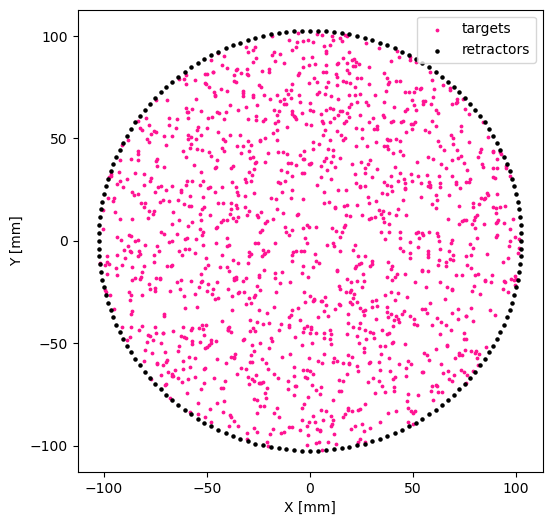

In [2]:
def rand_targets(R, n):
    """
    R = radius of disc
    n = number of targets to generate
    """
    key = jax.random.PRNGKey(0)
    key_p, key_q = jax.random.split(key)
    p = jax.random.uniform(key_p, shape=(n,))
    q = jax.random.uniform(key_q, shape=(n,))
    r = R * jnp.sqrt(p)
    theta = 2*jnp.pi*q

    return r * jnp.cos(theta), r * jnp.sin(theta)
    
# Specs
n_retractors = 168
r = 102.5 # mm, half of 205mm field
angles = np.linspace(0, 2*np.pi, n_retractors, endpoint=False) # placement of fibres
button_r = 4.5 # mm

# Synthetic targets
n_targets = 1400

x,y = rand_targets(r, n_targets)
plt.figure(figsize=(6,6))
plt.scatter(x,y, s=3, c='deeppink', label='targets')
plt.scatter(r*np.cos(angles), r*np.sin(angles), c='k', s=5, label='retractors')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.legend()

[135, 41, 4]
60.0


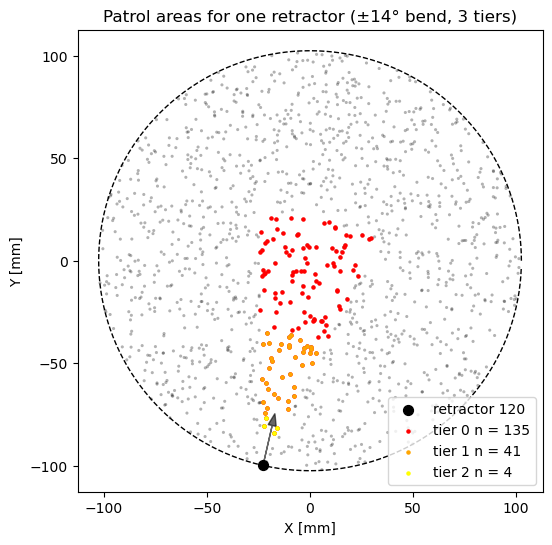

In [3]:
# Reachable targets per fibre
# Specs
n_retractors = 168
r = 102.5 # mm, half of 205mm field
button_r = 4.5 # mm

# Retractor positions
angles = np.linspace(0, 2*np.pi, n_retractors, endpoint=False) # placement of fibres
retractor_x = r * np.cos(angles)
retractor_y = r * np.sin(angles)

# Synthetic targets
# n_targets = 1400
# target_x,target_y = rand_targets(r, n_targets)

# VISUALIZE PATROL AREA
phi_max = np.deg2rad(14)  # max bend angle
reach = [1,0.7,0.3]  # fraction of r that each tier can reach
fibre_span_allowed = [r*1.2, r*0.65 , r*0.25]
cols = ['red', 'orange', 'yellow']

# Visualize for random given retractor_id
retractor_id = 120
retractor_x, retractor_y = r * np.cos(angles[retractor_id]), r * np.sin(angles[retractor_id])
norm_dir_inward = -np.array([retractor_x, retractor_y]) / np.sqrt(retractor_x**2 + retractor_y**2)

n_targets = 1400
px,py = rand_targets(r, n_targets)

# Vector from retractore to target wrt normal at retractor
vx = px - retractor_x 
vy = py - retractor_y
v_len = np.sqrt(vx**2 + vy**2)
vx /= v_len
vy /= v_len
ang = np.arccos(vx * norm_dir_inward[0] + vy * norm_dir_inward[1]) # angle between two unit vectorsy is arccos of their dot product

# Plot
plt.figure(figsize=(6,6))
plt.plot(r * np.cos(angles), r * np.sin(angles), 'k--', lw=1)
plt.scatter(retractor_x, retractor_y, s=50, c='k', label=f'retractor {retractor_id}')
plt.arrow(retractor_x, retractor_y, 20*norm_dir_inward[0], 20*norm_dir_inward[1], head_width=4, head_length=6, 
          fc='k', ec='k', alpha=0.6)

n_reached = []

for tier in range(3):
    fibre_span = np.sqrt((px - retractor_x)**2 + (py - retractor_y)**2)
    allowed = (fibre_span <= fibre_span_allowed[tier]) & (ang <= phi_max)
    plt.scatter(px[allowed], py[allowed], s=5, c=cols[tier], label=f'tier {tier} n = {len(px[allowed])}', zorder=10)
    n_reached.append(len(px[allowed]))

plt.scatter(px,py, c='k', edgecolor='none', alpha=0.3, s=5)
print(n_reached)
print(np.mean(n_reached))

plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.title('Patrol areas for one retractor (±14° bend, 3 tiers)')
plt.legend()
plt.show()


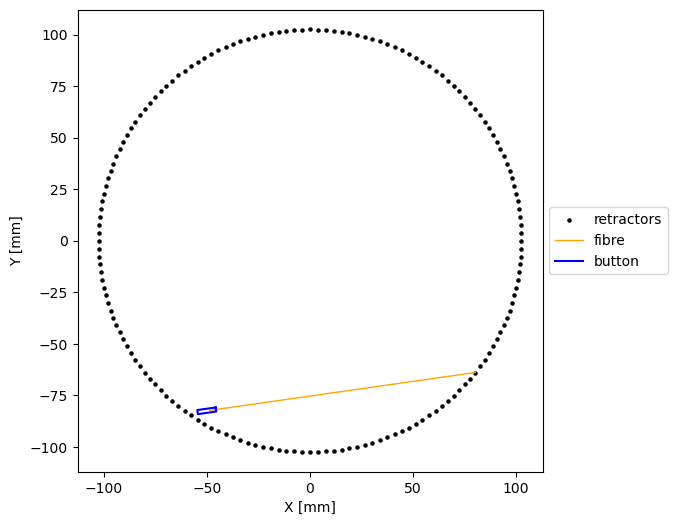

V1, V2, V3, V4 = [-45.75487578 -80.85083671] [-45.47251728 -82.83080481] [-54.38237373 -84.10141808] [-54.66473223 -82.12144998]


In [4]:
# Button area per fibre-target pair
# Specs
n_retractors = 168
r = 102.5 # mm
button_r = 4.5 # mm

angles = np.linspace(0, 2*np.pi, n_retractors, endpoint=False)
retractor_x = r * np.cos(angles)
retractor_y = r * np.sin(angles)

# Synthetic targets
n_targets = 1400
target_x, target_y = rand_targets(r, n_targets)

# Pick one random pair
i = np.random.randint(0, n_targets)
j = np.random.randint(0, n_retractors)

tx, ty = target_x[i], target_y[i]
rx, ry = retractor_x[j], retractor_y[j]

def return_vertices(R, T):
    # Direction from retractor to target
    vx = T[0] - R[0]
    vy = T[1] - R[1]
    # Angle of fibre from +x axis for rotation
    phi = np.arctan2(vy, vx)

    # Local button vertices (in mm) in a fibre-aligned frame
    # (e.g. width 2 mm, length 9 mm, inner edge near y=0)
    button_v1 = np.array([-1.0,  3.0])
    button_v2 = np.array([ 1.0,  3.0])
    button_v3 = np.array([ 1.0, -6.0])
    button_v4 = np.array([-1.0, -6.0])

    R = np.array([[np.cos(phi + np.pi/2), -np.sin(phi + np.pi/2)],
                [np.sin(phi + np.pi/2),  np.cos(phi + np.pi/2)]])

    def to_global(v_local):
        v_rot = R @ v_local # rotate
        return np.array([tx, ty]) + v_rot # translate to target

    V1 = to_global(button_v1)
    V2 = to_global(button_v2)
    V3 = to_global(button_v3)
    V4 = to_global(button_v4)

    return V1, V2, V3, V4

V1, V2, V3, V4 = return_vertices([rx, ry], [tx, ty]) 

plt.figure(figsize=(6, 6))
plt.scatter(retractor_x, retractor_y, c='k', s=5, label='retractors')
plt.plot([rx, tx], [ry, ty], 'orange', lw=1, label='fibre')
# plt.scatter([tx], [ty], c='deeppink', label='target')
button_x = [V1[0], V2[0], V3[0], V4[0], V1[0]]
button_y = [V1[1], V2[1], V3[1], V4[1], V1[1]]
plt.plot(button_x, button_y, 'b', label='button')

plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.axis('equal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print("V1, V2, V3, V4 =", V1, V2, V3, V4)


# Finding all fibres that can reach a given target, and the union of their button areas

In [5]:
import jax.numpy as jnp
from jax import vmap, jit

n_retractors = 168
n_tiers = 3
n_fibres = n_retractors * n_tiers

# Indexing functions
def fibre_id(retractor_id, tier_id): # Fibre ID from retractor & tier id
    if tier_id < 0 or tier_id >= n_tiers:
        raise ValueError("Invalid tier_id")
    return retractor_id * n_tiers + tier_id

def fibre_rt(fibre_id):
    r_id = fibre_id // n_tiers
    t_id = fibre_id % n_tiers
    return r_id, t_id # Retractor ID & tier ID from fibre ID


In [6]:
# Find all targets that can reach each fibre (vectorized)
# Setup specs ===============================================================
n_targets = 1400
r = 102.5 # mm, half of 205mm field
px,py = rand_targets(r, n_targets) # x- and y-coordinates of all random targets


# Retractor Specs 
angles = jnp.linspace(0, 2*jnp.pi, n_retractors, endpoint=False) # placement of fibres
retractor_x = jnp.asarray(r * jnp.cos(angles))
retractor_y = jnp.asarray(r * jnp.sin(angles))
fibre_span_allowed = jnp.asarray([r*0.25, r*0.65 , r*1.2]) # for tiers 0,1,2 (low-high)
phi_max = jnp.deg2rad(14)  # max bend angle

# ===========================================================================


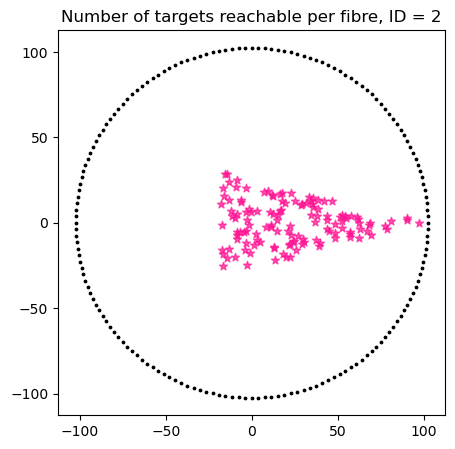

In [7]:
def targets_per_fibre(px, py, fibre):
    r_id, t_id = fibre_rt(fibre)
    rx, ry = retractor_x[r_id], retractor_y[r_id]
    norm_dir_inward = -jnp.array([rx, ry]) / jnp.sqrt(rx**2 + ry**2)

    # Vector from retractor to target
    vx = px - rx 
    vy = py - ry
    v_len = jnp.sqrt(vx**2 + vy**2)
    vx /= v_len
    vy /= v_len
    ang = jnp.arccos(vx * norm_dir_inward[0] + vy * norm_dir_inward[1]) # angle between two unit vectorsy is arccos of their dot product

    fibre_span = jnp.sqrt((px - rx)**2 + (py - ry)**2)
    allowed = (fibre_span <= fibre_span_allowed[t_id]) & (ang <= phi_max)
    return allowed


ID = 2
arr = targets_per_fibre(px,py,ID)
ls = jnp.where(arr)[0]

plt.figure(figsize=(5,5))
plt.scatter(px[ls], py[ls], marker='*', alpha=0.7, c='deeppink')
plt.scatter(retractor_x, retractor_y, c='k', s=3, label='retractors')
plt.title(f'Number of targets reachable per fibre, ID = {ID}')
plt.show()

In [8]:
# VECTORIZED FIBRE-TARGET REACHABILITY MATRIX

n_retractors = 168
n_tiers = 3
n_fibres = n_retractors * n_tiers

# Indexing functions (still fine to keep for other uses)
def fibre_id(retractor_id, tier_id):  # Fibre ID from retractor & tier id
    if tier_id < 0 or tier_id >= n_tiers:
        raise ValueError("Invalid tier_id")
    return retractor_id * n_tiers + tier_id

def fibre_rt(fibre_id):
    r_id = fibre_id // n_tiers
    t_id = fibre_id % n_tiers
    return r_id, t_id  # Retractor ID & tier ID from fibre ID

# -------------------------------------------------------------------------
# Setup specs =============================================================
n_targets = 1400
r = 102.5  # mm, half of 205mm field
px, py = rand_targets(r, n_targets)  # x- and y-coordinates of all random targets

# Retractor Specs 
angles = jnp.linspace(0, 2 * jnp.pi, n_retractors, endpoint=False)  # placement of fibres
retractor_x = jnp.asarray(r * jnp.cos(angles))  # shape (n_retractors,)
retractor_y = jnp.asarray(r * jnp.sin(angles))  # shape (n_retractors,)
fibre_span_allowed = jnp.asarray([r * 0.25, r * 0.65, r * 1.2])  # for tiers 0,1,2 (low-high)
phi_max = jnp.deg2rad(14)  # max bend angle (scalar)
# ========================================================================

# --- New: precompute retractor/tier for each fibre as JAX arrays --------
fibre_ids = jnp.arange(n_fibres)              # (F,)
r_id_for_fibre = fibre_ids // n_tiers         # (F,)
t_id_for_fibre = fibre_ids % n_tiers          # (F,)

@jit
def TF_reach_matrix(px,py):
    """
    Vectorized function to generate matrix for allowed target-fibre pairs given reach & bend constraints.
    """
    fibre_ids = jnp.arange(n_fibres)      # (F,)
    r_ids = fibre_ids // n_tiers          # (F,)
    t_ids = fibre_ids % n_tiers           # (F,)

    rx = retractor_x[r_ids]               # (F,)
    ry = retractor_y[r_ids]               # (F,)
    tier_span = fibre_span_allowed[t_ids] # (F,) / FOR EACH FIBRE

    pos_r = jnp.stack([rx, ry], axis=1)  # (F,2) (x,y) pos. for each retractor
    pos_r_norm_inward = - pos_r / jnp.linalg.norm(pos_r, axis=1, keepdims=True) # (F,) : unit vector in retractor-origin direction

    vx = px[None, :] - rx[:, None]     # (F, T) Broadcast dimensions!! So cool!
    vy = py[None, :] - ry[:, None]     # (F, T)
    v_len = jnp.sqrt(vx**2 + vy**2)   # (F, T)

    ux = vx / v_len   # (F, T)
    uy = vy / v_len   # (F, T)

    # Dot product between norm (inward) from retractor & unit vector from retractor to target
    dot = (ux * pos_r_norm_inward[:, 0:1] + uy * pos_r_norm_inward[:, 1:2])     # (F, T)

    # Angle between norm @ rectractor & vector to target
    ang = jnp.arccos(dot)       # (F, T)

    # Allowed span per fibre
    span_allowed = tier_span[:, None]  # (F, 1)

    # Check reachability
    allowed = (v_len <= span_allowed) & (ang <= phi_max)  # (F, T) bool

    return allowed


def targets_per_fibre(px, py, fibre):
    """
    Get targets for a single fibre using vectorization
    """
    allowed_all = TF_reach_matrix(px, py)  # (F, T)
    return allowed_all[fibre]                       # (T,) bool



# GET FOOTPRINTS

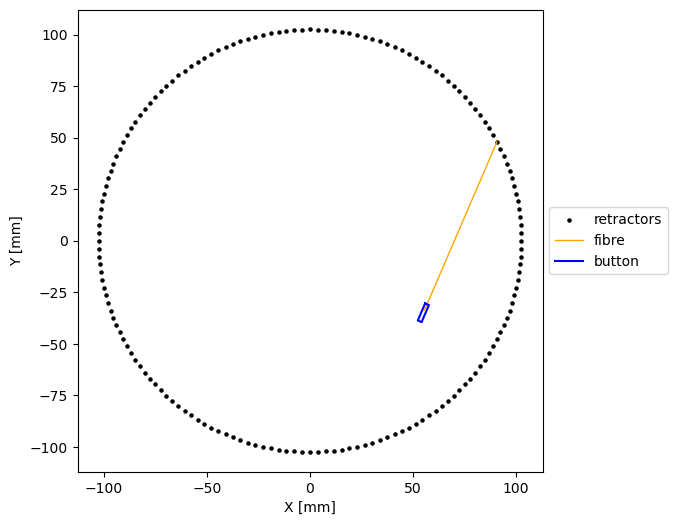

V1, V2, V3, V4 = [ 55.82350216 -30.41046845] [ 57.66051489 -31.20128083] [ 54.10185917 -39.46783812] [ 52.26484643 -38.67702574]


In [9]:
# Button area per fibre-target pair
# Specs
n_retractors = 168
r = 102.5 # mm
button_r = 4.5 # mm

angles = jnp.linspace(0, 2*np.pi, n_retractors, endpoint=False)
retractor_x = r * jnp.cos(angles)
retractor_y = r * jnp.sin(angles)

# Synthetic targets
n_targets = 1400
target_x, target_y = rand_targets(r, n_targets)

# Pick one random pair
i = np.random.randint(0, n_targets)
j = np.random.randint(0, n_retractors)


tx, ty = target_x[i], target_y[i]
rx, ry = retractor_x[j], retractor_y[j]

def return_vertices(R, T):
    # Direction from retractor to target
    vx = T[0] - R[0]
    vy = T[1] - R[1]
    # Angle of fibre from +x axis for rotation
    phi = np.arctan2(vy, vx)

    # Local button vertices (in mm) in a fibre-aligned frame
    # (e.g. width 2 mm, length 9 mm, inner edge near y=0)
    button_v1 = np.array([-1.0,  3.0])
    button_v2 = np.array([ 1.0,  3.0])
    button_v3 = np.array([ 1.0, -6.0])
    button_v4 = np.array([-1.0, -6.0])

    R = np.array([[np.cos(phi + np.pi/2), -np.sin(phi + np.pi/2)],
                [np.sin(phi + np.pi/2),  np.cos(phi + np.pi/2)]])

    def to_global(v_local):
        v_rot = R @ v_local # rotate
        return np.array([tx, ty]) + v_rot # translate to target

    V1 = to_global(button_v1)
    V2 = to_global(button_v2)
    V3 = to_global(button_v3)
    V4 = to_global(button_v4)

    return V1, V2, V3, V4

V1, V2, V3, V4 = return_vertices([rx, ry], [tx, ty]) 

plt.figure(figsize=(6, 6))
plt.scatter(retractor_x, retractor_y, c='k', s=5, label='retractors')
plt.plot([rx, tx], [ry, ty], 'orange', lw=1, label='fibre')
# plt.scatter([tx], [ty], c='deeppink', label='target')
button_x = [V1[0], V2[0], V3[0], V4[0], V1[0]]
button_y = [V1[1], V2[1], V3[1], V4[1], V1[1]]
plt.plot(button_x, button_y, 'b', label='button')

plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.axis('equal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print("V1, V2, V3, V4 =", V1, V2, V3, V4)


In [10]:
allowed = TF_reach_matrix(px,py)

In [11]:
# retractor_x, retractor_y: shape (F,)
# px, py: shape (T,)
# allowed: shape (F, T) bool

# Buton vertices (adjustable, these give 9mm length)
button_vertices_local = jnp.array([
    [-1,  6],
    [ 1,  6],
    [ 1, -3],
    [-1, -3],
])

@jit
def all_button_vertices(px, py, allowed):
    """
    Compute button polygon vertices for all fibre-target combinations.

    px, py: (T,)
    allowed: (F, T) bool - True if fibre f can reach target t
    returns: vertices of shape (F, T, 4, 2)
             vertices[f, t, k, :] = [x, y] of vertex k (k=0..3)
             entries are NaN where allowed[f, t] is False.
    """
    R = allowed.shape[0]             # n_retractors
    T = allowed.shape[1]             # n_targets

    # Get fiber IDs from Retractor IDs
    fibre_ids = jnp.arange(R)              # (R,)
    r_ids = fibre_ids // n_tiers          # (F,)

    # Broadcast fibre and target positions to (F, T)
    rx = retractor_x[r_ids, None]               # (F,1)
    ry = retractor_y[r_ids, None]               # (F,1)
    # rx = retractor_x[:, None]         # (F, 1)
    # ry = retractor_y[:, None]         # (F, 1)

    tx = px[None, :]                  # (1, T)
    ty = py[None, :]                  # (1, T)

    # Direction from retractor to target
    vx = tx - rx                      # (F, T)
    vy = ty - ry                      # (F, T)
    phi = jnp.arctan2(vy, vx)         # (F, T)
    theta = phi + jnp.pi / 2          # (F, T) FIRST ATTEMPT WAS PERP.?

    c = jnp.cos(theta)                # (F, T)
    s = jnp.sin(theta)                # (F, T)

    # Local vertices: (4,2) -> separate x,y components
    bx = button_vertices_local[:, 0]  # x-components (4,)
    by = button_vertices_local[:, 1]  # y-components (4,)

    # Broadcast local vertices to (F, T, 4)
    bx_broadcast = bx[None, None, :]          # (1, 1, 4)
    by_broadcast = by[None, None, :]          # (1, 1, 4)

    # Rotate each vertex for each (fibre, target)
    # ROTATION from (x,y) to (x',y') such that : x' = c*x - s*y & y' = s*x + c*y
    # Broadcast cos & sin from (F,T,1) to get final dimensions of (F,T,4) - rotated vertices for each Fibre-Target combination
    x_rot = c[:, :, None] * bx_broadcast - s[:, :, None] * by_broadcast   # (F, T, 4)
    y_rot = s[:, :, None] * bx_broadcast + c[:, :, None] * by_broadcast  # (F, T, 4)

    # Translate vertices to target position (tx, ty) !
    x_vertex = px[None, :, None] + x_rot                  # (F, T, 4)
    y_vertex = py[None, :, None] + y_rot                  # (F, T, 4)

    # Apply to reachability matrix: only return vertices for possible T-F combinations
    mask = allowed[:, :, None]                            # (F, T, 1)
    # print(rx.shape)
    # print(bx_broadcast.shape)
    # print(c.shape)
    # print(x_rot.shape)
    # print(x_vertex.shape)
    # print(mask.shape)
    x_vertex = jnp.where(mask, x_vertex, jnp.nan) # jnp.where: vlues drawn from x_vertex if mask (reach!) is True, NaN if not
    y_vertex = jnp.where(mask, y_vertex, jnp.nan)

    # Return final array of vertices
    vertices = jnp.stack([x_vertex, y_vertex], axis=-1)   # x_vertex, y_vertex have shape (F, T, 4), stack axis=-1 creates new rightmost axis! 
                                                          # Final shape: (F, T, 4, 2)
    return vertices


In [12]:
vertices = all_button_vertices(px, py, allowed)

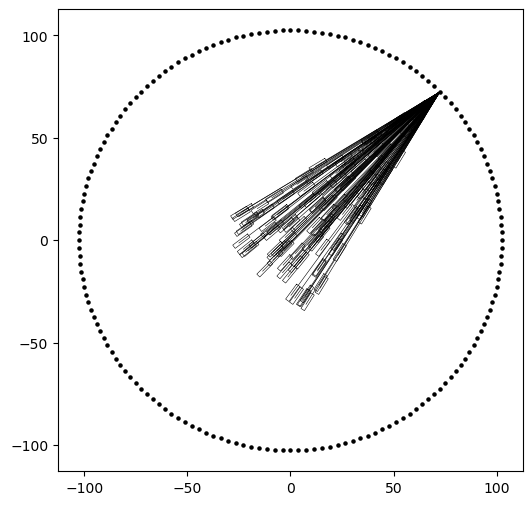

In [13]:
# PER FIBRE TARGETS

Fibre_ID = 65
fibre_ids = jnp.arange(168)              # (R,)
r_ids = fibre_ids // n_tiers          # (F,)

# Broadcast fibre and target positions to (F, T)
rx = retractor_x[r_ids]               # (F,)
ry = retractor_y[r_ids]               # (F,)

plt.figure(figsize=(6,6))
plt.scatter(retractor_x, retractor_y, c='k', s=5, label='retractors')

for Target_ID in np.where(allowed[Fibre_ID,:])[0]:
    vertices_x = vertices[Fibre_ID, Target_ID,:,:].T[0]
    vertices_x = jnp.append(vertices_x, vertices_x[0])
    vertices_y = vertices[Fibre_ID, Target_ID,:,:].T[1]
    vertices_y = jnp.append(vertices_y, vertices_y[0])

    plt.plot(vertices_x, vertices_y, c='k', zorder=12, lw=0.4)
    plt.plot([px[Target_ID], rx[Fibre_ID]], [py[Target_ID], ry[Fibre_ID]], c='k', lw=0.4)

    

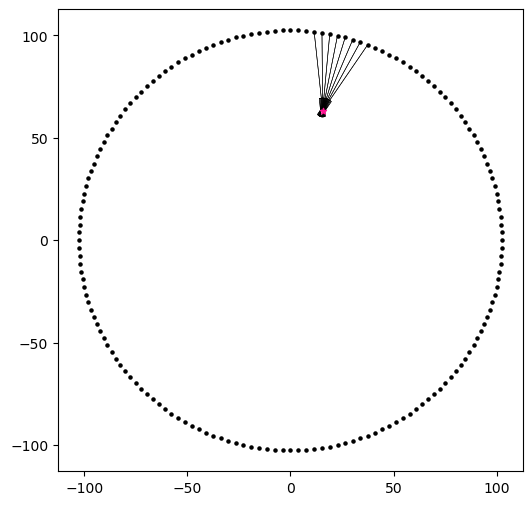

In [14]:
# PER TARGET FIBRES
 # ID 32O, 230, 100 interesting cases

Target_ID = 60
fibre_ids = jnp.arange(168*3)              # (R,)
r_ids = fibre_ids // n_tiers          # (F,)
rx = retractor_x[r_ids]               # (F,)
ry = retractor_y[r_ids]               # (F,)
rx.shape
plt.figure(figsize=(6,6))
plt.scatter(retractor_x, retractor_y, c='k', s=5, label='retractors')
plt.scatter(px[Target_ID], py[Target_ID], marker='*', c='deeppink', s=20, label='target', zorder=20)

# allowed has shape (504,1400) = (F,T)
for Fibre_ID in np.where(allowed[:,Target_ID])[0]:
    vertices_x = vertices[Fibre_ID, Target_ID,:,:].T[0]
    vertices_x = jnp.append(vertices_x, vertices_x[0])
    vertices_y = vertices[Fibre_ID, Target_ID,:,:].T[1]
    vertices_y = jnp.append(vertices_y, vertices_y[0])

    plt.plot(vertices_x, vertices_y, c='k', zorder=12, lw=0.4)
    plt.plot([px[Target_ID], rx[Fibre_ID]], [py[Target_ID], ry[Fibre_ID]], c='k', lw=0.4)

plt.show()
plt.close()


## Footprint bounding boxes

In [15]:
arr = jnp.tile(jnp.eye(5), (1,2,3,4))
print(arr.shape)
print("")
arr_T = jnp.transpose(arr, (1, 0, 2, 3))
print(arr_T.shape)

(1, 2, 15, 20)

(2, 1, 15, 20)


In [16]:
# Get bounding boxes for each Fibre-Target combination

@jax.jit
def compute_target_bboxes(vertices):
    # Transform vertices to per-target
    vertices_T = jnp.transpose(vertices, (1, 0, 2, 3))      # (T, F, 4, 2)
    vertices_T = vertices_T.reshape(vertices_T.shape[0], -1, 2)   # (T, F*4, 2) : ALL button verties for each target

    xmin = jnp.nanmin(vertices_T[..., 0], axis=1) # min of all x-coords
    xmax = jnp.nanmax(vertices_T[..., 0], axis=1) # max  "  "     "
    ymin = jnp.nanmin(vertices_T[..., 1], axis=1) # min of all y-coords
    ymax = jnp.nanmax(vertices_T[..., 1], axis=1) # max  "  "     "

    footprint_valid = jnp.isfinite(xmin) # False target has no reachable fibres at all
    return xmin, ymin, xmax, ymax, footprint_valid



In [17]:
identity = jnp.eye(5)
ascending = jnp.diag(jnp.array([1,2,3,4,5]))

overlap = (
    (identity < ascending)
)

overlap

Array([[False, False, False, False, False],
       [False,  True, False, False, False],
       [False, False,  True, False, False],
       [False, False, False,  True, False],
       [False, False, False, False,  True]], dtype=bool)

In [18]:
arr = jnp.array([1,2,3,4,5])
less = (
    (arr <= 2) &
    (arr <= 5)
)

print(arr)
print(less)

[1 2 3 4 5]
[ True  True False False False]


In [19]:
@jax.jit
def compute_bbox_overlap(xmin, ymin, xmax, ymax, footprint_valid):
    # Broadcast bounds to compare pair-wise bounding box coordinates
    xmin_i = xmin[:, None];  xmin_j = xmin[None, :] # (T, 1) & (1, T) respectively
    xmax_i = xmax[:, None];  xmax_j = xmax[None, :]
    ymin_i = ymin[:, None];  ymin_j = ymin[None, :]
    ymax_i = ymax[:, None];  ymax_j = ymax[None, :]

    # Boxes overlap IF the min of one vertex is less than the max of the other in both X and Y
    overlap = (
        (xmax_i >= xmin_j) &
        (xmax_j >= xmin_i) &
        (ymax_i >= ymin_j) &
        (ymax_j >= ymin_i)
    ) # Boolean array shape (T,T)

    # Consider which targets have NO valid F-T connections
    valid_i = footprint_valid[:, None] # (T, 1)
    valid_j = footprint_valid[None, :] # (1, T)

    overlap = overlap & valid_i & valid_j # combine bool arrays - only where all are True is True returned

    # Remove diagonal entries (self-overlap)
    T = xmin.shape[0]
    overlap = overlap & (~jnp.eye(T, dtype=bool)) # Set all (i,i) entries to False

    # Symmetrize - keep only upper triangle as in Terret (2014)
    overlap = jnp.triu(overlap, k=1) # keep upper triangle
    overlap = overlap | overlap.T # mirror to lower

    return overlap


In [20]:
jnp.eye(3, dtype=bool)

Array([[ True, False, False],
       [False,  True, False],
       [False, False,  True]], dtype=bool)

In [21]:
reachable_Ts = jnp.any(allowed, axis=0) # collabse fibre dimension, check if ANY fibre can reach a given target

In [22]:
print(allowed.shape) # original, (F, T)
print(reachable_Ts.shape) # collapsed fibre dimension

(504, 1400)
(1400,)


In [23]:
# GET ALWAYS COLLIDING TARGET PAIRS
min_sep = 2 # mm; min. distance of separation below which buttons overlap

@jax.jit
def always_collide(px, py, reachable_Ts, min_sep):
    # Get target-target separation via broadcasting
    xi = px[:, None]      # (T, 1)
    yi = py[:, None]      # (T, 1)
    dx = xi - xi.T        # (T, T)
    dy = yi - yi.T        # (T, T)
    d2 = dx**2 + dy**2    # (T, T) squared distances between targets

    # Ignore self-distances
    T = px.shape[0] # n_targets
    d2 = d2 + jnp.eye(T) * jnp.inf # add identity matrix scaled by inf to distances**2

    # Check for separation-based collision
    collide = jnp.sqrt(d2) < min_sep # (T, T) bool

    # Limit to target pairs that are both reachable by some fibre
    both_reachable = reachable_Ts[:, None] & reachable_Ts[None, :] # BROADCAST (T, T) bool
    always_collide = collide & both_reachable # reachable pairs that always collide

    # Keep upper triangle
    always_collide = jnp.triu(always_collide, k=1) # return only upper triangle
    always_collide = always_collide | always_collide.T # force symmetry
    always_collide = jnp.where(jnp.eye(T, dtype=bool), False, always_collide) # force diagonal = False

    return always_collide

In [24]:
always_collide_mat = always_collide(px, py, reachable_Ts, min_sep)

In [25]:
num_pairs = always_collide_mat.sum() // 2
num_pairs

Array(341, dtype=int32)

In [26]:
xmin, ymin, xmax, ymax, footprint_valid = compute_target_bboxes(vertices)
bbox_overlap = compute_bbox_overlap(xmin, ymin, xmax, ymax, footprint_valid)

never_button_collision = (~always_collide_mat) & (~bbox_overlap) # No bbox overlap & not always colliding
needs_fibre_level = bbox_overlap & (~always_collide_mat) # Bounding box overlap & not ALWAYs colliding

collision_kind = jnp.where(
    always_collide_mat,
    1,
    jnp.where(never_button_collision, -1, 0)
)


In [27]:
jnp.where(needs_fibre_level[1]) # SAME RESULT AS WE WOULD GET WITH SHAPELY!!!

(Array([ 102,  266,  357,  394,  399,  429,  537,  597,  875,  885, 1041,
        1051, 1089, 1183, 1194, 1244, 1300, 1369], dtype=int32),)

## Fibre-level tests

In [28]:
# Get edges of each button
# vertices has shape (F, T, 4, 2) - vertices are ordered, say V0, V1, V2, V3
# on the axis with index 2, if we jnp.roll with shift = -1, get ordering V1, V2, V3, V0
# subtracting gives V1-V0, V2-V1, V3-V2, V0-V3
# edges[f, t, k] is edge from vertex k to k+1 mod 4
edges = jnp.roll(vertices, shift=-1, axis=2) - vertices  # (F, T, 4, 2)


In [29]:
# Function to check segment-segment overlap
def seg_seg_intersect(p, r, q, s):
    
    # Input: p,r,q,s are (...,2) arrays representing segments p->p+r and q->q+s
    # Output: boolean array of shape (...) indicating whether segments intersect

    cross = lambda a, b: a[..., 0]*b[..., 1] - a[..., 1]*b[..., 0] # 2D cross product

    rxs = cross(r, s)
    q_p = q - p
    q_pxr = cross(q_p, r) # is separation of q & p || to r (or s)? If yes: vectors are not just parallel but collinear

    # parallel or collinear
    parallel = jnp.isclose(rxs, 0)
    # collinear = jnp.isclose(q_pxr, 0) # Is this necessary??

    # For non-parallel, find t,u parameters at intersection. If both ∈ [0,1] POI ∈ of both segments
    t = cross(q_p, s) / rxs
    u = cross(q_p, r) / rxs

    # Intersect: True where NOT parallel, and t,u both ∈ [0,1]
    intersect = (~parallel) & (t >= 0) & (t <= 1) & (u >= 0) & (u <= 1)
    return intersect


## Reachable fibres per target

In [30]:
# allowed: JAX array (F, T)
allowed_np = np.array(allowed)  # (F, T)

# Python list: for each target t, the array of fibre indices that can reach it
reachable_fibres_per_target = [
    np.where(allowed_np[:, t])[0].astype(np.int32)
    for t in range(allowed_np.shape[1])
]

# Sanity check: average number of fibres per target
avg_nfib = np.mean([len(fibs) for fibs in reachable_fibres_per_target])
print("Average fibres per target:", avg_nfib)


Average fibres per target: 24.00642857142857


# Fibre-fibre collision block for one target pair

In [31]:
@jax.jit
def fibre_collision_block(vertices, fibre_idx_i, fibre_idx_j, t1, t2):
    """
    Compute a fibre-fibre collision block for a single target pair (t1, t2).

    vertices: (F, T, 4, 2) JAX array of button vertices
    fibre_idx_i: (Fi,) int32 JAX array of fibre IDs for target t1
    fibre_idx_j: (Fj,) int32 JAX array of fibre IDs for target t2
    t1, t2: Python ints (or 0D JAX arrays) for target indices

    Returns:
      block: (Fi, Fj) bool JAX array
             True if fibre_i (on t1) collides with fibre_j (on t2)
    """
    # Gather polygons for fibres reaching t1 and t2
    # verts_i: (Fi, 4, 2), verts_j: (Fj, 4, 2)
    verts_i = vertices[fibre_idx_i, t1, :, :]  # (Fi, 4, 2)
    verts_j = vertices[fibre_idx_j, t2, :, :]  # (Fj, 4, 2)

    # Edges: edge k is from vertex k -> k+1 (mod 4)
    edges_i = jnp.roll(verts_i, -1, axis=1) - verts_i  # (Fi, 4, 2)
    edges_j = jnp.roll(verts_j, -1, axis=1) - verts_j  # (Fj, 4, 2)

    # Broadcast to compare every edge of i-poly vs every edge of j-poly
    # p, r correspond to poly i; q, s correspond to poly j
    # Shapes after broadcasting:
    #   p, r, q, s: (Fi, Fj, 4, 4, 2)
    p = verts_i[:, None, :, None, :]    # (Fi, 1, 4, 1, 2)
    r = edges_i[:, None, :, None, :]    # (Fi, 1, 4, 1, 2)
    q = verts_j[None, :, None, :, :]    # (1, Fj, 1, 4, 2)
    s = edges_j[None, :, None, :, :]    # (1, Fj, 1, 4, 2)

    intersects = seg_seg_intersect(p, r, q, s)  # (Fi, Fj, 4, 4)

    # If any edge pair intersects, the two buttons collide
    edge_hit = jnp.any(intersects, axis=(2, 3))  # (Fi, Fj)

    # Could add point-in-polygon checks here also??

    return edge_hit  # (Fi, Fj) bool


In [32]:
from tqdm import tqdm

# Convert JAX boolean matrices to NumPy for pair indexing
needs_fibre_level_np = np.array(needs_fibre_level)
collision_kind_np = np.array(collision_kind)

# Find all target pairs that require fibre-level checks
pairs_i, pairs_j = np.where(needs_fibre_level_np)
pairs = list(zip(pairs_i, pairs_j))

print("Number of target pairs needing fibre-level checks:", len(pairs))

# Dictionary to hold fibre-level collision blocks
# Key: (t1, t2)  with t1 < t2 (we'll store upper triangle only)
# Value: 2D NumPy bool array of shape (len(F_t1), len(F_t2))
collision_blocks = {}

for t1, t2 in tqdm(pairs, desc="Building fibre-level collision blocks"):
    if t2 < t1:
        t1, t2 = t2, t1

    fibres_t1 = reachable_fibres_per_target[t1]
    fibres_t2 = reachable_fibres_per_target[t2]

    if len(fibres_t1) == 0 or len(fibres_t2) == 0:
        continue

    block = fibre_collision_block(
        vertices,
        jnp.array(fibres_t1, dtype=jnp.int32),
        jnp.array(fibres_t2, dtype=jnp.int32),
        int(t1),
        int(t2),
    )

    collision_blocks[(t1, t2)] = np.array(block, dtype=bool)


Number of target pairs needing fibre-level checks: 14178


Building fibre-level collision blocks: 100%|██████████| 14178/14178 [04:23<00:00, 53.84it/s]  


## SANITY CHECKS

### 1.

In [33]:
print("Counts:")
print("  ALWAYS  (+1):", np.sum(collision_kind_np == 1))
print("  NEVER   (-1):", np.sum(collision_kind_np == -1))
print("  MAYBE    (0):", np.sum(collision_kind_np == 0))


Counts:
  ALWAYS  (+1): 682
  NEVER   (-1): 1945140
  MAYBE    (0): 14178


### 2.

In [34]:
print("Number of fine-grained blocks:", len(collision_blocks))


Number of fine-grained blocks: 7089


In [35]:
np.sum(needs_fibre_level_np)

14178

### 3.

In [36]:
import random

# pick a random pair that needs fibre-level checks
t1, t2 = random.choice(list(collision_blocks.keys()))

block = collision_blocks[(t1, t2)]

print("Random pair:", (t1, t2))
print("Block shape:", block.shape)
print("Any collisions:", np.any(block))
print("Number of colliding fibre pairs:", np.sum(block))


Random pair: (455, 906)
Block shape: (37, 38)
Any collisions: True
Number of colliding fibre pairs: 892


In [37]:
def check_pair_consistency(t1, t2):
    fibres_t1 = reachable_fibres_per_target[t1]
    fibres_t2 = reachable_fibres_per_target[t2]
    block = collision_blocks[(t1, t2)]

    # verify shape matches
    assert block.shape == (len(fibres_t1), len(fibres_t2))

    # test 5 random fibre pairs
    for _ in range(5):
        fA = random.choice(fibres_t1)
        fB = random.choice(fibres_t2)

        # local indices
        i = np.where(fibres_t1 == fA)[0][0]
        j = np.where(fibres_t2 == fB)[0][0]

        print(f"Target pair {(t1, t2)}: Fibre pair {(fA, fB)} → block[{i},{j}] = {block[i,j]}")


In [38]:
check_pair_consistency(t1, t2)


Target pair (455, 906): Fibre pair (37, 52) → block[22,34] = True
Target pair (455, 906): Fibre pair (23, 503) → block[13,37] = True
Target pair (455, 906): Fibre pair (44, 32) → block[25,21] = True
Target pair (455, 906): Fibre pair (44, 13) → block[25,8] = True
Target pair (455, 906): Fibre pair (22, 13) → block[12,8] = True


In [39]:
zero_blocks = [(t1,t2) for (t1,t2),block in collision_blocks.items() if not np.any(block)]
len(zero_blocks)


2763

## Visualize

In [40]:
from matplotlib.patches import Polygon

def overlay_reachable_fibres_for_target(ax, t,
                                        allowed,
                                        vertices,
                                        px, py,
                                        retractor_x, retractor_y,
                                        n_tiers,
                                        line_color="k",
                                        poly_color="k",
                                        poly_lw=0.4,
                                        alpha=0.6):
    """
    Plot all fibres that can reach target t:
      - button polygons
      - line from target to corresponding retractor
    """
    allowed_np   = np.array(allowed)
    vertices_np  = np.array(vertices)

    fibre_ids = np.where(allowed_np[:, t])[0]

    for Fibre_ID in fibre_ids:
        # map fibre -> retractor index
        r_id = Fibre_ID // n_tiers
        rx, ry = retractor_x[r_id], retractor_y[r_id]

        # button polygon around this target
        poly = vertices_np[Fibre_ID, t, :, :]  # (4,2)
        poly_closed = np.vstack([poly, poly[0]])

        ax.plot(poly_closed[:, 0], poly_closed[:, 1],
                color=poly_color, lw=poly_lw, alpha=alpha, zorder=12)

        # fibre line from target to retractor
        ax.plot([px[t], rx], [py[t], ry],
                color=line_color, lw=poly_lw, alpha=alpha, zorder=10)


In [41]:
def footprint_rect(minx, miny, maxx, maxy):
    return np.array([
        [minx, miny],
        [maxx, miny],
        [maxx, maxy],
        [minx, maxy],
        [minx, miny],
    ])

def plot_target_pair_setup(t1, t2,
                           px, py,
                           minx, miny, maxx, maxy,
                           retractor_x, retractor_y,
                           ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    if title is not None:
        ax.set_title(title)

    # Retractors
    ax.scatter(retractor_x, retractor_y, c="k", s=5, label="Retractors", zorder=1)

    # Targets
    ax.scatter([px[t1], px[t2]],
               [py[t1], py[t2]],
               c=["tab:blue", "tab:orange"],
               s=50, zorder=20, label="Targets")

    # Footprints
    for t, col, lab in [(t1, "blue", f"Footprint {t1}"),
                        (t2, "red",  f"Footprint {t2}")]:
        if np.isfinite(minx[t]):
            poly = footprint_rect(minx[t], miny[t], maxx[t], maxy[t])
            ax.plot(poly[:, 0], poly[:, 1], color=col, lw=2, label=lab)

    ax.set_aspect("equal", "box")
    ax.set_xlabel("X [mm]")
    ax.set_ylabel("Y [mm]")
    ax.legend(loc="best")
    return ax


In [42]:
def plot_never_colliding_pair(t1, t2,
                              px, py,
                              minx, miny, maxx, maxy,
                              allowed, vertices,
                              retractor_x, retractor_y,
                              n_tiers):
    fig, ax = plt.subplots(figsize=(7, 7))
    plot_target_pair_setup(
        t1, t2, px, py, minx, miny, maxx, maxy,
        retractor_x, retractor_y, ax=ax,
        title=f"Targets {t1} & {t2}: NEVER colliding"
    )

    # all fibres that can reach each target
    overlay_reachable_fibres_for_target(
        ax, t1, allowed, vertices,
        px, py, retractor_x, retractor_y, n_tiers,
        line_color="gray", poly_color="gray", alpha=0.6
    )
    overlay_reachable_fibres_for_target(
        ax, t2, allowed, vertices,
        px, py, retractor_x, retractor_y, n_tiers,
        line_color="gray", poly_color="gray", alpha=0.6
    )

    plt.show()


In [43]:
def plot_always_colliding_pair(t1, t2,
                               px, py,
                               minx, miny, maxx, maxy,
                               allowed, vertices,
                               retractor_x, retractor_y,
                               n_tiers):
    fig, ax = plt.subplots(figsize=(7, 7))
    plot_target_pair_setup(
        t1, t2, px, py, minx, miny, maxx, maxy,
        retractor_x, retractor_y, ax=ax,
        title=f"Targets {t1} & {t2}: ALWAYS colliding"
    )

    # all fibres that can reach each target
    overlay_reachable_fibres_for_target(
        ax, t1, allowed, vertices,
        px, py, retractor_x, retractor_y, n_tiers,
        line_color="gray", poly_color="gray", alpha=0.6
    )
    overlay_reachable_fibres_for_target(
        ax, t2, allowed, vertices,
        px, py, retractor_x, retractor_y, n_tiers,
        line_color="gray", poly_color="gray", alpha=0.6
    )

    plt.show()


In [44]:
def plot_sometimes_colliding_pair(
    t1, t2,
    px, py,
    minx, miny, maxx, maxy,
    vertices,
    allowed,
    retractor_x, retractor_y,
    n_tiers,
    collision_blocks,
    reachable_fibres_per_target,
    collision_kind_np,
    max_combos=None,
):
    kind = int(collision_kind_np[t1, t2])
    if kind != 0:
        print(f"Pair ({t1}, {t2}) is not 'sometimes' (collision_kind={kind}).")
        return

    # Get correct (t_lo, t_hi) key
    t_lo, t_hi = (t1, t2) if t1 < t2 else (t2, t1)
    key = (t_lo, t_hi)
    if key not in collision_blocks:
        print(f"No fibre-level block stored for pair {key}.")
        return

    block = collision_blocks[key]
    fibs_lo = reachable_fibres_per_target[t_lo]
    fibs_hi = reachable_fibres_per_target[t_hi]

    if (t_lo, t_hi) == (t1, t2):
        fibs_t1, fibs_t2 = fibs_lo, fibs_hi
        block_t = block
    else:
        fibs_t1, fibs_t2 = fibs_hi, fibs_lo
        block_t = block.T

    vertices_np = np.array(vertices)

    fig, ax = plt.subplots(figsize=(7, 7))
    plot_target_pair_setup(
        t1, t2, px, py, minx, miny, maxx, maxy,
        retractor_x, retractor_y, ax=ax,
        title=(f"Targets {t1} & {t2}: SOMETIMES colliding\n"
               "Green = valid fibre pairs, Red = colliding fibre pairs")
    )

    # First: overlay **all fibres** that can reach each target (as in your snippet)
    overlay_reachable_fibres_for_target(
        ax, t1, allowed, vertices,
        px, py, retractor_x, retractor_y, n_tiers,
        line_color="k", poly_color="k", alpha=0.3
    )
    overlay_reachable_fibres_for_target(
        ax, t2, allowed, vertices,
        px, py, retractor_x, retractor_y, n_tiers,
        line_color="k", poly_color="k", alpha=0.3
    )

    # Now emphasize individual fibre–fibre combos with colours
    combos = [(i, j) for i in range(len(fibs_t1)) for j in range(len(fibs_t2))]
    if max_combos is not None and len(combos) > max_combos:
        random.shuffle(combos)
        combos = combos[:max_combos]

    for i, j in combos:
        f1 = int(fibs_t1[i])
        f2 = int(fibs_t2[j])
        collides = bool(block_t[i, j])

        poly1 = vertices_np[f1, t1, :, :]
        poly2 = vertices_np[f2, t2, :, :]

        if collides:
            # collision: red outlines
            for poly, col in [(poly1, "red"), (poly2, "red")]:
                patch = Polygon(poly, closed=True,
                                facecolor="none",
                                edgecolor=col,
                                linewidth=1.0,
                                alpha=0.9)
                ax.add_patch(patch)
        else:
            # allowed: green transparent fill
            for poly in (poly1, poly2):
                patch = Polygon(poly, closed=True,
                                facecolor="lime",
                                edgecolor="green",
                                linewidth=0.8,
                                alpha=0.4)
                ax.add_patch(patch)

    ax.set_aspect("equal", "box")
    plt.show()


In [46]:
xmin

Array([  8.40288 , -37.402794,  33.43507 , ..., -32.197304, -31.089315,
        13.795279], dtype=float32)

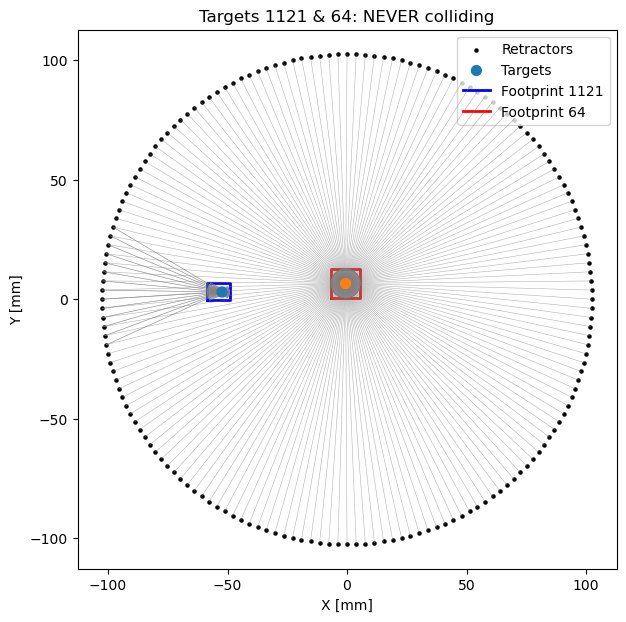

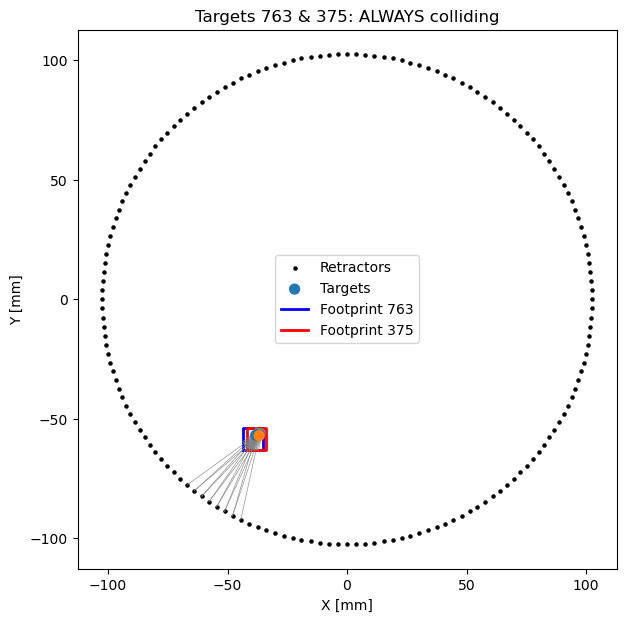

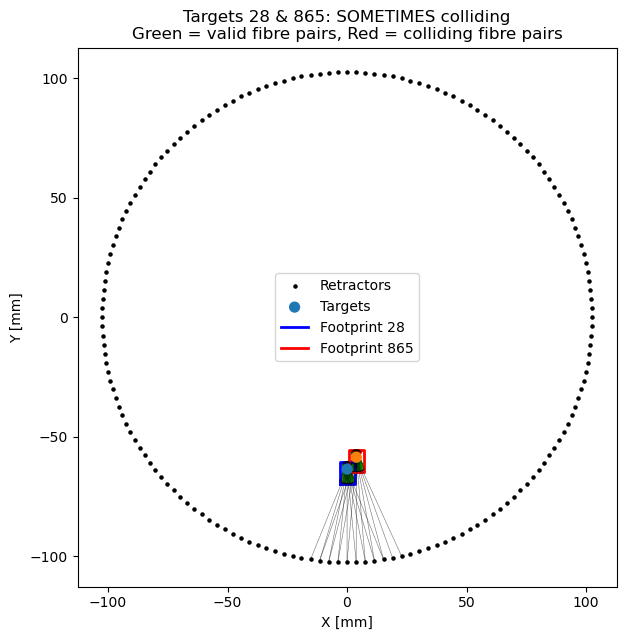

In [51]:
# NEVER colliding example

minx_np = np.asarray(xmin)
miny_np = np.asarray(ymin)
maxx_np = np.asarray(xmax)
maxy_np = np.asarray(ymax)

idxs_never = np.argwhere(collision_kind_np == -1)
t1, t2 = map(int, random.choice(idxs_never))
plot_never_colliding_pair(t1, t2,
                          px, py,
                          minx_np, miny_np, maxx_np, maxy_np,
                          allowed, vertices,
                          retractor_x, retractor_y,
                          n_tiers)

# ALWAYS colliding example
idxs_always = np.argwhere(collision_kind_np == 1)
t1, t2 = map(int, random.choice(idxs_always))
plot_always_colliding_pair(t1, t2,
                           px, py,
                           minx_np, miny_np, maxx_np, maxy_np,
                           allowed, vertices,
                           retractor_x, retractor_y,
                           n_tiers)

# SOMETIMES colliding example
idxs_some = np.argwhere(collision_kind_np == 0)
t1, t2 = map(int, random.choice(idxs_some))
plot_sometimes_colliding_pair(
    t1, t2,
    px, py,
    minx_np, miny_np, maxx_np, maxy_np,
    vertices,
    allowed,
    retractor_x, retractor_y,
    n_tiers,
    collision_blocks,
    reachable_fibres_per_target,
    collision_kind_np,
    max_combos=300,  # to avoid over-plotting
)


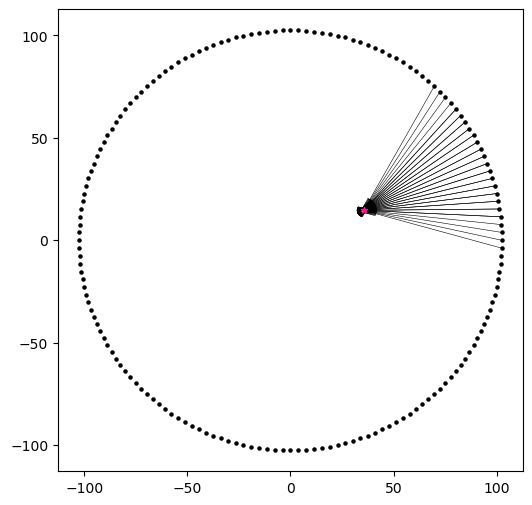

In [ ]:
# PER TARGET FIBRES
 # ID 32O, 230, 100 interesting cases

Target_ID = 54
fibre_ids = jnp.arange(168*3)              # (R,)
r_ids = fibre_ids // n_tiers          # (F,)
rx = retractor_x[r_ids]               # (F,)
ry = retractor_y[r_ids]               # (F,)
rx.shape
plt.figure(figsize=(6,6))
plt.scatter(retractor_x, retractor_y, c='k', s=5, label='retractors')
plt.scatter(px[Target_ID], py[Target_ID], marker='*', c='deeppink', s=20, label='target', zorder=20)

# allowed has shape (504,1400) = (F,T)
for Fibre_ID in np.where(allowed[:,Target_ID])[0]:
    vertices_x = vertices[Fibre_ID, Target_ID,:,:].T[0]
    vertices_x = jnp.append(vertices_x, vertices_x[0])
    vertices_y = vertices[Fibre_ID, Target_ID,:,:].T[1]
    vertices_y = jnp.append(vertices_y, vertices_y[0])

    plt.plot(vertices_x, vertices_y, c='k', zorder=12, lw=0.4)
    plt.plot([px[Target_ID], rx[Fibre_ID]], [py[Target_ID], ry[Fibre_ID]], c='k', lw=0.4)

plt.show()
plt.close()
